# 👖 Variational Autoencoders - Fashion-MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

The code has been adapted from the excellent [VAE tutorial](https://keras.io/examples/generative/vae/) created by Francois Chollet, available on the Keras website.

In [19]:
!pip install tensorflow

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [21]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

## 1. Prepare the data <a name="prepare"></a>

In [22]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [23]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [24]:
# Show some items of clothing from the training set
display(x_train)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## 2. Build the variational autoencoder <a name="build"></a>

In [25]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [29]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [30]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [31]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [32]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 268s 441ms/step - kl_loss: 3.5288 - reconstruction_loss: 200.9083 - total_loss: 204.4371 - val_kl_loss: 5.1366 - val_loss: 142.0518 - val_reconstruction_loss: 136.9152
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 263s 439ms/step - kl_loss: 5.0307 - reconstruction_loss: 131.7208 - total_loss: 136.7515 - val_kl_loss: 5.1038 - val_loss: 137.9975 - val_reconstruction_loss: 132.8937
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 265s 442ms/step - kl_loss: 5.0264 - reconstruction_loss: 129.5680 - total_loss: 134.5944 - val_kl_loss: 5.2693 - val_loss: 136.6964 - val_reconstruction_loss: 131.4270
Epoch 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 266s 443ms/step - kl_loss: 5.1059 - reconstruction_loss: 128.4199 - total_loss: 133.5259 - val_kl_loss: 5.1582 - val_loss: 136.2844 - val_reconstruction_loss: 131.1261
Epoch 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 264s 440ms/step - kl_loss: 5.1170 - reconstruction_loss: 127.9021 - total_loss: 133.0191 - val_kl_loss: 5.1689 - val_loss: 136.2142 - val_reconstruction_loss: 131.0453


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [38]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [40]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [41]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[5.55468387e-06],
         [9.33997981e-08],
         [3.61330166e-08],
         ...,
         [4.34659952e-09],
         [2.60965241e-08],
         [9.73537226e-06]],

        [[5.11861877e-08],
         [6.81175727e-10],
         [3.91795901e-10],
         ...,
         [2.05775078e-10],
         [6.48663512e-10],
         [1.04612627e-06]],

        [[6.50121947e-08],
         [3.66072794e-09],
         [5.27759703e-08],
         ...,
         [1.63800030e-06],
         [1.00919908e-06],
         [2.86522827e-05]],

        ...,

        [[1.18797292e-08],
         [2.01227901e-09],
         [2.09169571e-07],
         ...,
         [9.74381464e-07],
         [1.03192477e-07],
         [3.32756940e-06]],

        [[1.42112899e-08],
         [8.59482208e-10],
         [3.64899044e-08],
         ...,
         [8.35180725e-09],
         [2.79919043e-09],
         [4.05855275e-07]],

        [[1.98850762e-06],
         [3.10480999e-07],
         [1.48126583e-06],
         ...,
 

## 4. Embed using the encoder <a name="encode"></a>

In [42]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [43]:
# Some examples of the embeddings
print(z[:10])

[[-1.3827163  -0.26565194]
 [ 0.2855957  -0.66222334]
 [ 2.449379    0.1651343 ]
 [ 2.1601148   1.6523123 ]
 [ 0.1219161   0.1349844 ]
 [ 2.2410855   0.16145042]
 [ 0.26630238  0.98898983]
 [ 0.03855722  0.4992381 ]
 [-1.6228315   2.5177114 ]
 [-1.5380502   1.0549718 ]]


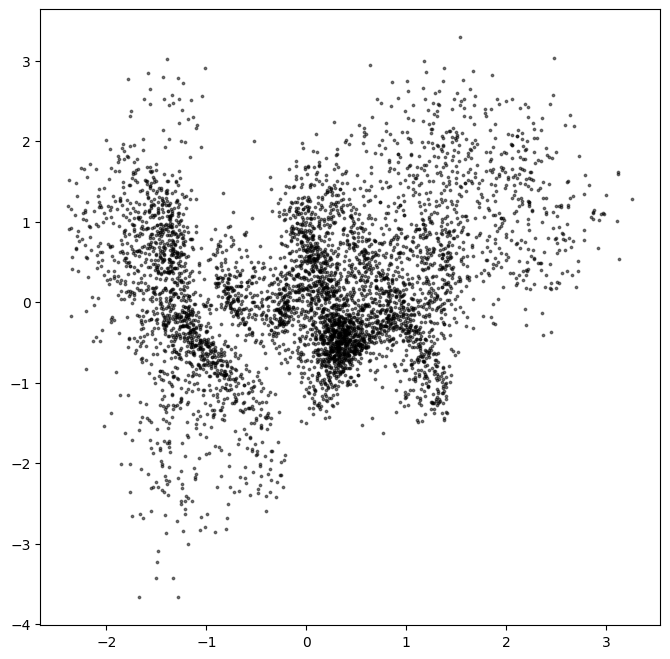

In [44]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## 5. Generate using the decoder <a name="decode"></a>

In [45]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [46]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [47]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

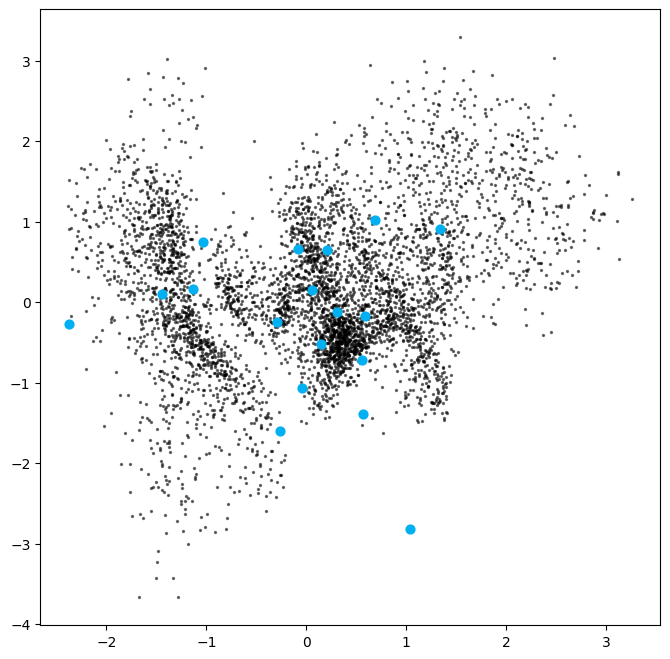

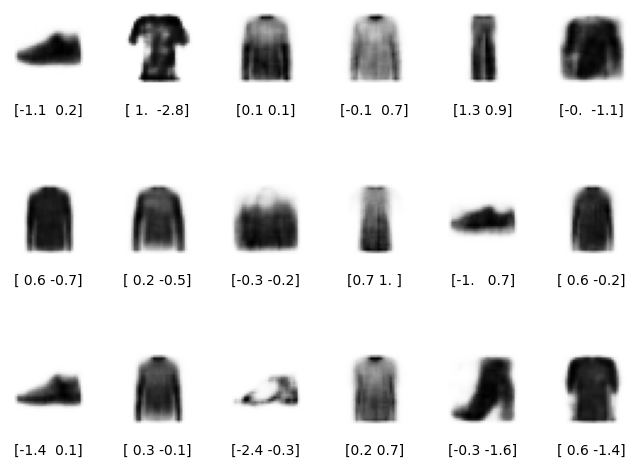

In [48]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. Explore the latent space <a name="explore"></a>

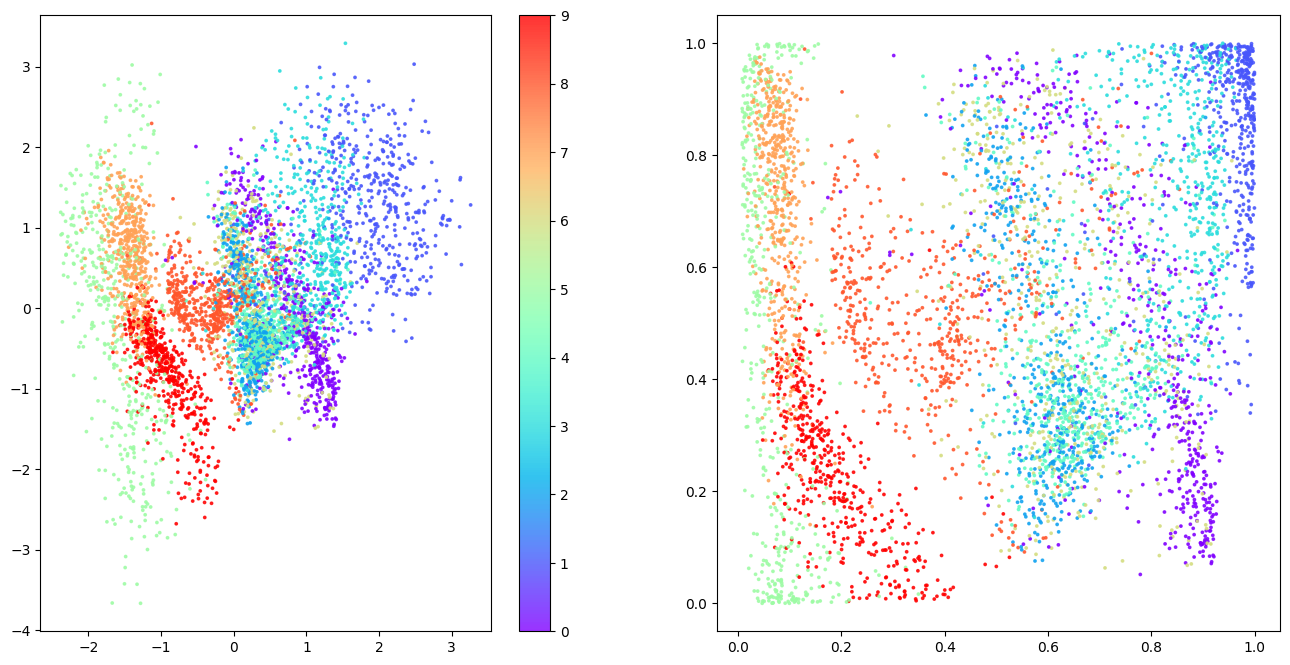

In [49]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


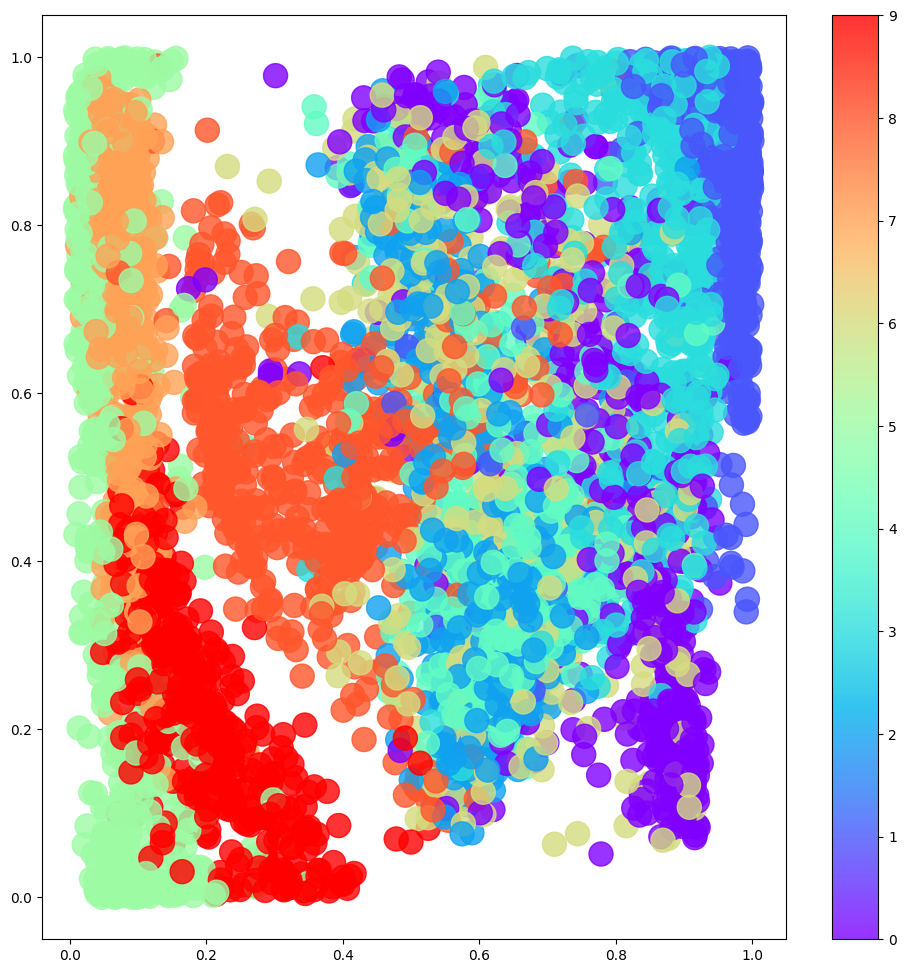

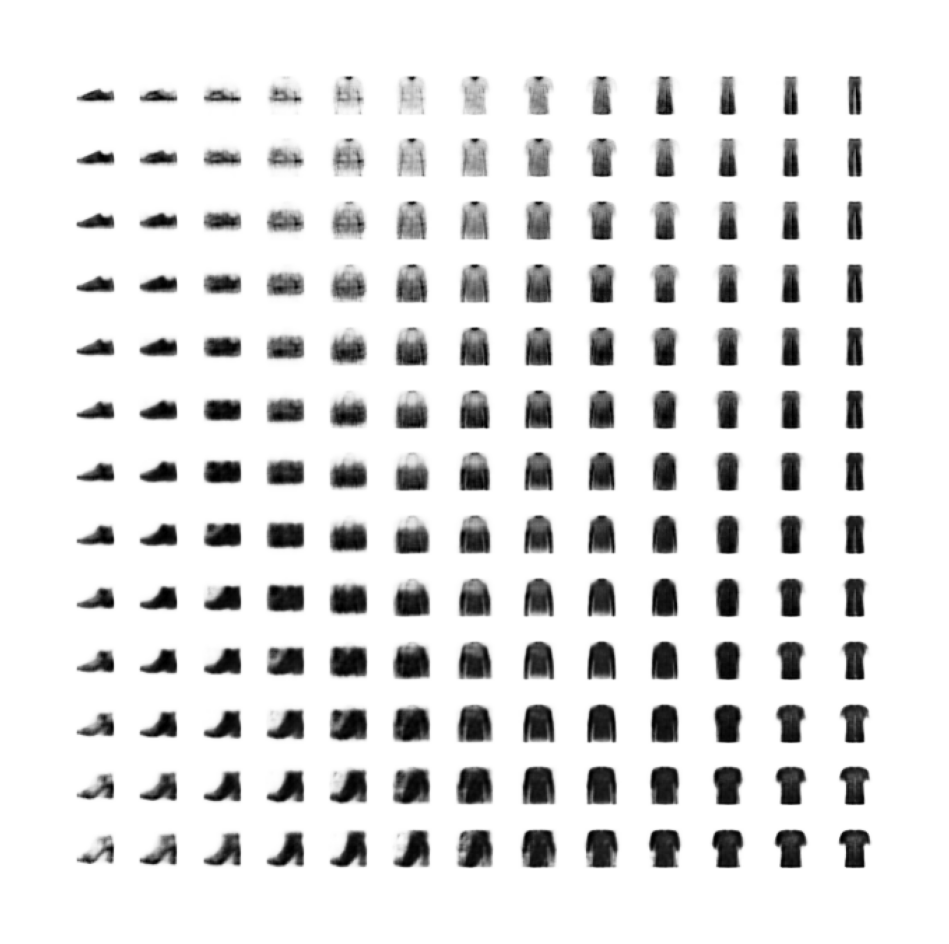

In [50]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [51]:
import os

if not os.path.exists("./models"):
    os.makedirs("./models")